# Week 6. Reading Case 3 data
Cognitive Systems for Health Technology Applications<br>
Sakari Lukkarinen & Juha Kopu, 24.2.2018<br>
[Helsinki Metropolia University of Applied Sciences](http:/www.metropolia.fi/en)

## Processing raw data
Based on listing 6.8 (p. 189) Chollet: Deep Learning with Python, 2018.

In [1]:
import os

ohsumed_dir = '../ohsumed-first-20000-docs/'
train_dir = os.path.join(ohsumed_dir, 'training')

labels = []
texts = []

# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)

## Tokenize the text of the raw data
Based on listing 6.9 (p. 189)

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 300
max_words = 20000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Using TensorFlow backend.


Found 30857 unique tokens


### Shape the data and labels

In [3]:
from keras.utils.np_utils import to_categorical

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)


print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 300)
Shape of labels tensor: (10433, 23)


### Shuffle the data and labels

In [4]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

## Build the model
Listing 6.7 (p. 187)

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(L), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 8)            160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2458624   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 23)                5911      
Total params: 2,886,935
Trainable params: 2,886,935
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [6]:
import time

t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 10,
                   batch_size = 32,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/10
8346/8346 [==============================] - 17s - loss: 2.7556 - acc: 0.1867 - val_loss: 2.5853 - val_acc: 0.2472
Epoch 2/10
8346/8346 [==============================] - 16s - loss: 2.3296 - acc: 0.2872 - val_loss: 2.6468 - val_acc: 0.2142
Epoch 3/10
8346/8346 [==============================] - 17s - loss: 1.8815 - acc: 0.3912 - val_loss: 2.9112 - val_acc: 0.1667
Epoch 4/10
8346/8346 [==============================] - 18s - loss: 1.5192 - acc: 0.4802 - val_loss: 3.2078 - val_acc: 0.1394
Epoch 5/10
8346/8346 [==============================] - 18s - loss: 1.2744 - acc: 0.5189 - val_loss: 3.5823 - val_acc: 0.1442
Epoch 6/10
8346/8346 [==============================] - 19s - loss: 1.1140 - acc: 0.5359 - val_loss: 3.7423 - val_acc: 0.1260
Epoch 7/10
8346/8346 [==============================] - 20s - loss: 0.9982 - acc: 0.5389 - val_loss: 4.1498 - val_acc: 0.1236
Epoch 8/10
8346/8346 [==============================] - 19s - loss: 0.

## Training results

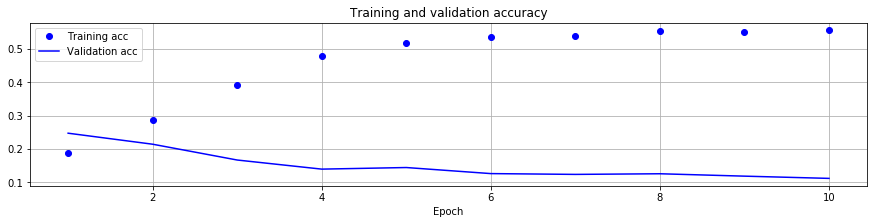

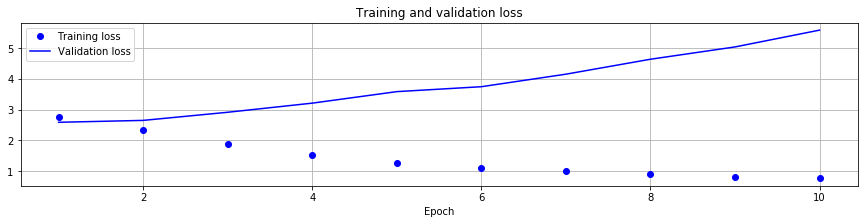

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Metrics results

In [8]:
# Calculate the predictions
predictions = model.predict(data)
y_pred = np.argmax(predictions, axis = 1)

In [9]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score

In [10]:
# Classification results per class
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.58      0.40      0.48       423
          1       0.41      0.68      0.51       158
          2       0.45      0.58      0.51        65
          3       0.57      0.68      0.62      1163
          4       0.49      0.70      0.58       283
          5       0.53      0.56      0.54       588
          6       0.51      0.69      0.58       100
          7       0.59      0.36      0.45       473
          8       0.56      0.58      0.57       125
          9       0.49      0.73      0.59       621
         10       0.63      0.51      0.56       162
         11       0.54      0.54      0.54       491
         12       0.52      0.61      0.56       281
         13       0.62      0.70      0.66      1249
         14       0.50      0.52      0.51       215
         15       0.48      0.82      0.61       200
         16       0.77      0.36      0.49       295
         17       0.68      0.53      0.60   

In [11]:
# Confusion matrix
cm = confusion_matrix(labels, y_pred)
print(np.array2string(cm, max_line_width = 100))

[[171  21   4   6  13  34   5   7   1  22   3  20  12  20   7   5   1   3   1  24  12   1  30]
 [  1 107   2   5   0   1   5   1   0   6   0   2   3   5   0   1   0   0   1  13   0   0   5]
 [  1   3  38   2   0   2   0   1   1   5   1   1   2   2   0   1   0   1   0   3   0   0   1]
 [  8   7   1 793  11  30  23  14  17  35   9  20  30  13  15   9   6   5   6  50  15   3  43]
 [  2   0   0   6 199   5   2   2   0  17   1   2   1   5   1   9   0   4   3   5   4   2  13]
 [ 11  10   3  63   5 332   1   6   0  21   0   9   4  19   4   6   2   4   1  13   7   3  64]
 [  0   1   0   8   3   0  69   1   1   2   0   0   1   4   1   1   1   0   0   1   1   0   5]
 [ 16  12   2  56   5   8   1 171   8  19   0   9   9  31   6   9   0   3   0  37  19   1  51]
 [  2   5   0  13   2   0   1   8  73   2   1   2   1   1   0   2   0   0   0   3   1   0   8]
 [  2   4   4  20  16   5   1   4   2 455   1   4   7  25   3   9   1   2   0   9  15   1  31]
 [  4   2   5  11   4   0   1   0   0  21  82   1 

In [33]:
print(texts[indices[512]])

Role of prostaglandin E1 in reducing pulmonary vascular resistance in an experimental model of acute lung injury.
 To determine the role and efficacy of prostaglandin E1 (PGE1) on the cardiopulmonary derangements induced by glass bead embolism, two studies were performed.
 In the first study, a dose response of PGE1 was tested in six animals that were first embolized with sufficient glass beads to double the pulmonary artery pressure (PAP).
 This study demonstrated that PGE1 reduced PAP and cardiac output by a preload-mediated mechanism, as evidenced by a reduction in the right ventricular (RV) end-diastolic segment length, at doses of 15 and 30 ng/kg.min.
 The second study was performed in two groups of animals, the control group (n = 6), and the treated group (n = 6), which were given PGE1 at 15 ng/kg.min after the PAP had been doubled by glass bead embolism.
 RV preload was kept constant.
 This study demonstrated that there was no difference in pulmonary vascular resistance between 

True class:  7
Predicted class: 13
Predictions per class:
[  1.00e-04   3.77e-05   8.23e-05   1.54e-03   9.88e-04   4.32e-04
   3.38e-05   3.11e-01   2.44e-05   1.82e-03   8.77e-06   1.81e-04
   7.99e-03   3.85e-01   9.42e-04   2.72e-02   1.13e-04   1.96e-03
   1.16e-02   7.76e-04   1.20e-04   2.33e-01   1.50e-02]


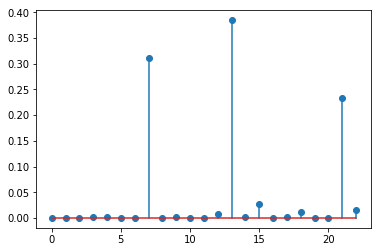

In [40]:
print('True class: ', labels[512])
print('Predicted class:', y_pred[512])
print('Predictions per class:')
print(np.array2string(predictions[512], precision = 2))

plt.stem(predictions[512])
plt.show()

In [39]:
np.__version__

'1.13.3'